modelos a comparar: 

# vamos a probar los 5 (excepto el LSTM, ese solo para suavizado vs no suavizado) para: datos suavizados, FPLS, FPCA, 
(esto obviamente seria imposible si tuviera muchos datos)

Dense NN
Medida de profundidad
Knn?
XGBOOST

pasos:
1- Definir funcion que te entrene los 5 modelos y te cree las comparaciones (roc, validacion, etc)
2- Correrlo en cada caso


## Intentaremos detectar si en una partida algún jugador hacer trampas
Como tenemos una cantidad manejable de datos, vamos a probar 3 modelos, cada uno con sus puntos fuertes y débiles.
Hay bastante margen de optimización, la elección de hiperparámetros debería ser tratada con más cuidado, así como deberíamos consdierar más métricas de evaluación. 

## Red neuronal densa con masking en los valores que faltan:

In [1]:
import numpy as np
def pad_sequences(sequences, max_len=None, pad_value=None):
    """
    Rellena con el último valor de la secuencia hasta max_len.
    """
    if not max_len:
        return np.array(sequences, dtype=np.float32)
    
    padded = []
    for seq in sequences:
        seq = list(seq)
        if len(seq) >= max_len:
            padded.append(seq[:max_len])
        else:
            if not pad_value:
                pad_value = seq[-1] if seq else 0.0  # Poner 0.0 si la secuencia está vacía
            padded_seq = seq + [pad_value] * (max_len - len(seq))
            padded.append(padded_seq)
    return np.array(padded, dtype=np.float32)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import f1_score




class DenseNNClassifier:
    """
    Clase que define una red neuronal densa con capa de enmascaramiento para clasificación binaria.
    
    Parámetros:
    - X (list of lists): Matriz de características, cada elemento es una lista de longitud variable.
    - y (list or np.array): Etiquetas binarias (0 o 1).
    - params (dict): Diccionario con parámetros para la inicialización y el entrenamiento.
        - 'padding_length' (int, opcional): Longitud máxima para padding. Por defecto: None, no se realiza padding.
        - 'mask_value' (float, opcional): Valor a utilizar como máscara. Por defecto: None, no se realiza masking.
        - 'test_size' (float, opcional): Proporción del conjunto de prueba (por defecto: 0.2).
        - 'val_size' (float, opcional): Proporción del conjunto de validación (por defecto: 0.1).
        - 'lr' (float, opcional): Tasa de aprendizaje para el optimizador Adam (por defecto: 0.001).
        - 'epochs' (int, opcional): Número de épocas de entrenamiento (por defecto: 25).
        - 'batch_size' (int, opcional): Tamaño del batch (por defecto: 32).
        - 'verbose' (int, opcional): Nivel de verbosidad (por defecto: 1).
    """

    def __init__(self, X, y, params):
        self.params = params
        
        # Obtener los parámetros del diccionario o establecer valores predeterminados
        self.padding_length = params.get('padding_length', None)
        self.mask_value = params.get('mask_value', None)
        self.test_size = params.get('test_size', 0.2)
        self.val_size = params.get('val_size', 0.1)
        self.epochs = self.params.get('epochs', 25)
        self.batch_size = self.params.get('batch_size', 32)
        self.verbose = self.params.get('verbose', 1)
        self.lr = self.params.get('lr', 0.001)
        
        self.input_dim = self.padding_length if self.padding_length else X.shape[1]
        
        
        self.model = None
        self.name = "NN densa"
        self.umbral = 0.5
        self.fpr = self.tpr = self.f1 = self.roc_auc = None
        self.history = None
        
        # Padding de las secuencias hasta la longitud máxima
        X_padded = pad_sequences(X, max_len=self.padding_length, pad_value=self.mask_value)


        # División en conjuntos de entrenamiento, validación y prueba
        y = np.asarray(y, dtype=np.float32)
        X_train, X_temp, y_train, y_temp = train_test_split(
            X_padded, y, test_size=self.test_size + self.val_size, stratify=y, random_state=42
        )
        # División temp en val / test
        rel_val = self.val_size / (self.test_size + self.val_size)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=42
        )

        self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test
        
        print(f"Datos preparados para {self.name}:")
        print(f"  - Train: {self.X_train.shape}, Val: {self.X_val.shape}, Test: {self.X_test.shape}")

    def build(self):
        """
        Construye y compila el modelo de red neuronal densa según los parámetros dados.
        """
        
        if self.padding_length and self.mask_value:
            input_layer = tf.keras.layers.Masking(mask_value=self.mask_value, input_shape=(self.input_dim,)) 
        else:
            input_layer = tf.keras.layers.InputLayer(input_shape=(self.input_dim,))
        
        self.model = tf.keras.Sequential([
            input_layer,
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=Adam(learning_rate=self.lr), loss='binary_crossentropy', metrics=['accuracy'])
        
        print(f"Modelo {self.name} inicializado.")

    def train(self):
        """
        Entrena el modelo en los datos de entrenamiento usando los parámetros dados.
        """
        if self.model is None:
            self.build_model()
        
        self.history = self.model.fit(self.X_train, self.y_train, 
                       epochs=self.epochs, 
                       batch_size=self.batch_size, 
                       validation_data=(self.X_val, self.y_val),
                       verbose=self.verbose)
        
        print(f"Entrenamiento de {self.name} completado.")

    def evaluate(self):
        """
        Evalúa el modelo en el conjunto de prueba y calcula métricas ROC y F1.
        """
        y_pred_prob = self.model.predict(self.X_test)

        # Curva ROC y AUC
        self.fpr, self.tpr, _ = roc_curve(self.y_test, y_pred_prob)
        self.roc_auc = auc(self.fpr, self.tpr)

        umbrales = np.linspace(0, 1, 101)
        self.f1 = []

        old_umbral = self.umbral
        for umbral in umbrales:
            self.umbral = umbral
            y_pred = self.predict(self.X_test, transform=False)
            self.f1.append(f1_score(self.y_test, y_pred))
        self.umbral = old_umbral
                
        print(f"Evaluación de {self.name} completada.")
 

    def predict(self, X, transform=True):
        """
        Genera predicciones binarias para un conjunto de datos dado.
        
        Parámetros:
        - X (list of lists o array-like): Datos de entrada, cada elemento es una lista de longitud variable.
        - transform (bool): Indica si transformar los datos X.
        
        Retorna:
        - np.array: Predicciones binarias (0 o 1).
        """
        if transform and self.padding_length:
            probs = self.model.predict(pad_sequences(X, max_len=self.padding_length, pad_value=self.mask_value))
        else:
            probs = self.model.predict(X)
        return (probs > self.umbral).astype(int)


## Clasificador XGBoost extendiendo los datos con padding

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

class XGBClassifier:
    """
    Clase que define un clasificador XGBoost para datos secuenciales,
    usando padding por último valor.

    Parámetros:
    - X (list of lists): Matriz de características, cada elemento es una lista de longitud variable.
    - y (list or np.array): Etiquetas binarias (0 o 1).
    - params (dict): Parámetros de configuración, que incluyen:
        - 'padding_length' (int, opcional): Longitud máxima para padding. Por defecto: None, no se realiza padding.
        - 'test_size' (float, opcional): Proporción del conjunto de prueba (por defecto: 0.2).
        - 'val_size' (float, opcional): Proporción del conjunto de validación (por defecto: 0.1).
        - 'xgb_params' (dict, opcional): Parámetros a pasar al XGBClassifier (por defecto: {'eval_metric': 'logloss', 'n_estimators': 200, 'random_state': 42}).
        - 'verbose' (int, opcional): Nivel de verbosidad (por defecto: 0).
    """

    def __init__(self, X, y, params):
        self.params = params
        
        self.padding_length = params.get('padding_length', None)
        self.input_dim = self.padding_length if self.padding_length else X.shape[1]
        self.test_size = params.get('test_size', 0.2)
        self.val_size = params.get('val_size', 0.1)
        self.xgb_params = params.get('xgb_params', {
            'eval_metric': 'logloss',
            'n_estimators': 200,
            'random_state': 42
        })
        self.verbose = params.get('verbose', 0)
        
        self.model = None
        self.name = "XGBoost classifier"
        self.umbral = 0.5
        
        self.fpr = self.tpr = self.f1 = self.roc_auc = None

        # Padding de las secuencias
        X_padded = pad_sequences(X, self.padding_length)
        y = np.asarray(y, dtype=np.float32)
        # División en train / temp
        X_train, X_temp, y_train, y_temp = train_test_split(
            X_padded, y, test_size=self.test_size + self.val_size, stratify=y, random_state=42
        )
        # División temp en val / test
        rel_val = self.val_size / (self.test_size + self.val_size)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=42
        )

        self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

        print(f"Datos preparados para {self.name}:")
        print(f"  - Train: {self.X_train.shape}, Val: {self.X_val.shape}, Test: {self.X_test.shape}")

    def build(self):
        """
        Crea la instancia de XGBClassifier con los parámetros dados.
        """
        self.model = xgb.XGBClassifier(**self.xgb_params)
        print(f"Modelo {self.name} inicializado.")

    def train(self):
        """
        Entrena el modelo en los datos de entrenamiento usando los parámetros dados.
        """
        if self.model is None:
            self.build_model()
        self.model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_val, self.y_val)],
            verbose=self.verbose
        )
        print(f"Entrenamiento de {self.name} completado.")

    def evaluate(self):
        """
        Evalúa el modelo en el conjunto de prueba y calcula métricas ROC y F1.
        """
        y_pred_prob = self.model.predict_proba(self.X_test)[:, 1]

        # ROC
        self.fpr, self.tpr, _ = roc_curve(self.y_test, y_pred_prob)
        self.roc_auc = auc(self.fpr, self.tpr)

        umbrales = np.linspace(0, 1, 101)
        self.f1 = []

        old_umbral = self.umbral
        for umbral in umbrales:
            self.umbral = umbral
            y_pred = self.predict(self.X_test, transform=False)
            self.f1.append(f1_score(self.y_test, y_pred))
        self.umbral = old_umbral
        
        print(f"Evaluación de {self.name} completada.")

    def predict(self, X, transform=True):
        """
        Genera predicciones binarias para un conjunto de datos dado.
        
        Parámetros:
        - X (list of lists o array-like): Datos de entrada, cada elemento es una lista de longitud variable.
        - transform (bool): Indica si transformar los datos X.
        
        Retorna:
        - np.array: Predicciones binarias (0 o 1).
        """
        if transform:
            probs = self.model.predict_proba(pad_sequences(X, self.padding_length))[:, 1]
        else:
            probs = self.model.predict_proba(X)[:, 1]
        return (probs > self.umbral).astype(int)


## Clasificador por KNN con extendiendo los datos con padding.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from skfda.ml.classification import KNeighborsClassifier as fKNN
from skfda.representation import FDataGrid


class KNNClassifier:
    """
    Clase que define un clasificador KNN para datos secuenciales, usando padding por último valor y
    grid search para encontrar el mejor número de vecinos (n_neighbors).

    Parámetros:
    - X (list of lists): Matriz de características, cada elemento es una lista de longitud variable.
    - y (list or np.array): Etiquetas binarias (0 o 1).
    - params (dict): Parámetros de configuración, que incluyen:
        - 'padding_length' (int, opcional): Longitud máxima para padding. Por defecto: None, no se realiza padding.
        - test_size (float, opcional): Proporción del conjunto de prueba (por defecto: 0.2).
        - val_size (float, opcional): Proporción del conjunto de validación (por defecto: 0.1).
        - grid_search (bool, opcional): Indica si realizar un grid_search para optimizar el número de vecinos (por defecto: False).
    """
    def __init__(self, X, y, params):
        self.params = params
        
        self.padding_length = params.get('padding_length', None)
        self.input_dim = self.padding_length if self.padding_length else X.shape[1]
        self.test_size = params.get('test_size', 0.2)
        self.val_size = params.get('val_size', 0.1)
        self.grid_search = params.get('grid_search', False)
        
        self.model = None
        self.name = "KNN classifier"
        self.umbral = 0.5
        
        self.fpr = self.tpr = self.f1 = self.roc_auc = None
        

        # Padding de las secuencias
        X_padded = pad_sequences(X, self.padding_length)
        y = np.asarray(y, dtype=np.float32)
        
        X_train, X_temp, y_train, y_temp = train_test_split(
            X_padded, y, test_size=self.test_size + self.val_size, stratify=y, random_state=42
        )
        # División temp en val / test
        rel_val = self.val_size / (self.test_size + self.val_size)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=42
        )
        # Convertir cada partición a FDataGrid con grid_points
        grid = np.linspace(0, 1, self.input_dim)
        self.X_train = FDataGrid(data_matrix=X_train, grid_points=grid)
        self.X_val   = FDataGrid(data_matrix=X_val,   grid_points=grid)
        self.X_test  = FDataGrid(data_matrix=X_test,  grid_points=grid)

        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

        print(f"Datos preparados para {self.name}:")
        print(f"  - Train: {self.X_train.data_matrix.shape}, Val: {self.X_val.data_matrix.shape}, Test: {self.X_test.data_matrix.shape}")

    def build(self):
        """
        Crea la instancia de KNeighborsClassifier de skfda con los parámetros dados en y realiza un GridSearch
        para encontrar el mejor número de vecinos.
        """
        
        if self.grid_search:
            knn = fKNN()
            model = GridSearchCV(knn, {'n_neighbors': range(1, 9, 2)}, cv=5, verbose=1)
        else:
            model = fKNN(n_neighbors=5)
            
        self.model = model
        print(f"Modelo {self.name} inicializado.")

    def train(self):
        """
        Entrena el modelo en los datos de entrenamiento usando los parámetros dados. 
        """
        if self.model is None:
            self.build_model()
        self.model.fit(self.X_train, self.y_train)
        print(f"Entrenamiento de {self.name} completado.")

    def evaluate(self):
        """
        Evalúa el modelo en el conjunto de prueba y calcula métricas ROC y F1.
        """
        y_pred_prob = self.model.predict_proba(self.X_test)[:, 1]

        # ROC
        self.fpr, self.tpr, _ = roc_curve(self.y_test, y_pred_prob)
        self.roc_auc = auc(self.fpr, self.tpr)

        umbrales = np.linspace(0, 1, 101)
        self.f1 = []

        old_umbral = self.umbral
        for umbral in umbrales:
            self.umbral = umbral
            y_pred = self.predict(self.X_test, transform=False)
            self.f1.append(f1_score(self.y_test, y_pred))
        self.umbral = old_umbral

        print(f"Evaluación de {self.name} completada.")

    def predict(self, X, transform=True):
        """
        Genera predicciones binarias para un conjunto de datos dado.
        
        Parámetros:
        - X (list of lists o array-like): Datos de entrada, cada elemento es una lista de longitud variable.
        - transform (bool): Indica si transformar los datos X.
        
        Retorna:
        - np.array: Predicciones binarias (0 o 1).
        """
        if transform:
            X_func  = FDataGrid(data_matrix=pad_sequences(X, self.padding_length), grid_points=np.linspace(0, 1, self.input_dim))
            probs = self.model.predict_proba(X_func)[:, 1]
        else:
            probs = self.model.predict_proba(X)[:, 1]
        return (probs > self.umbral).astype(int)


## Probamos los modelos sin modificar nada

In [21]:
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


nn_params = {'padding_length': 150, 'mask_value': 42, 'verbose': 0}
xgb_params = {'padding_length': 150, 'verbose': 0}
knn_params = {'padding_length': 150, 'verbose': 0}

X = pickle.load(open("evals.pkl", "rb"))
y = pickle.load(open("cheating.pkl", "rb"))

models = [DenseNNClassifier(X, y, nn_params), XGBClassifier(X, y, xgb_params), KNNClassifier(X, y, knn_params)]

for model in models:
    model.build()
    
    print(f"Entrenando {model.name}...")
    model.train()
    print(f"Evaluando {model.name}...")
    model.evaluate()
    



Datos preparados para NN densa:
  - Train: (10271, 150), Val: (2934, 150), Test: (1468, 150)
Datos preparados para XGBoost classifier:
  - Train: (10271, 150), Val: (2934, 150), Test: (1468, 150)
Datos preparados para KNN classifier:
  - Train: (10271, 150, 1), Val: (2934, 150, 1), Test: (1468, 150, 1)
Modelo NN densa inicializado.
Entrenando NN densa...
Epoch 1/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5101 - loss: 1.5633 - val_accuracy: 0.5198 - val_loss: 0.7788
Epoch 2/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5362 - loss: 0.8216 - val_accuracy: 0.5433 - val_loss: 0.7506
Epoch 3/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5426 - loss: 0.7547 - val_accuracy: 0.5467 - val_loss: 0.7430
Epoch 4/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5564 - loss: 0.7233 - val_accuracy: 0.5153 - val_loss: 0.7693
Epoch 5/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5443 - loss: 0.7329 - val_accuracy: 0.5211 - val_loss: 0.7589
Epo

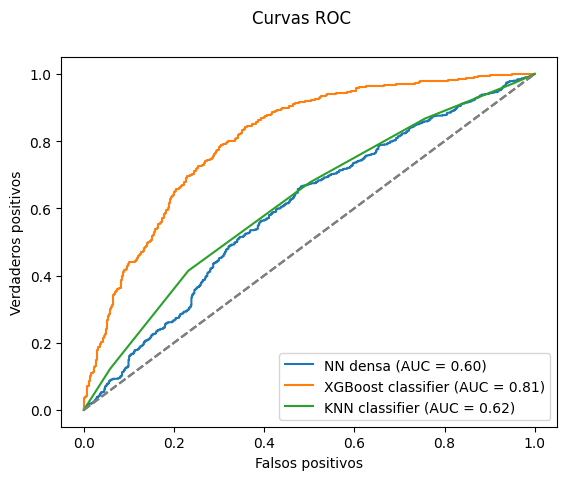

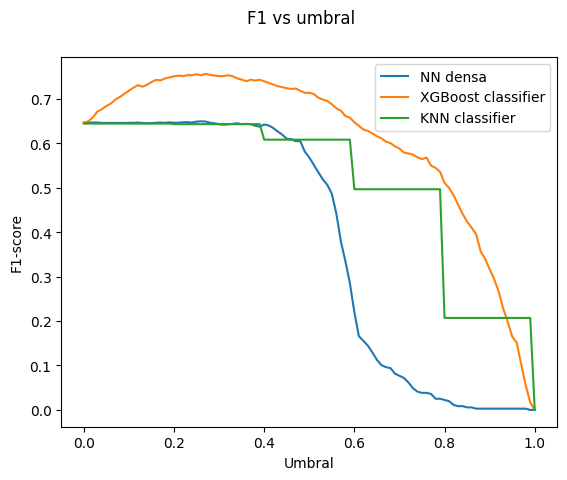

In [22]:
plt.figure()
plt.suptitle("Curvas ROC")
for model in models:
    plt.plot(model.fpr, model.tpr, label=f'{model.name} (AUC = {model.roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.legend()
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')

plt.figure()
plt.suptitle("F1 vs umbral")
for model in models:
    plt.plot(np.linspace(0, 1, 101), model.f1, label=f'{model.name}')
    plt.legend()
    plt.xlabel('Umbral')
    plt.ylabel('F1-score')


plt.show()

## Vamos a cargar los datos ya paddeados, y suavizarlos a ver si mejora.

In [132]:
X = np.load('X.npy')
y = np.load('y.npy')


X_func = FDataGrid(data_matrix=X, grid_points=np.linspace(0, 1, 150))

In [133]:
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from skfda.preprocessing.smoothing.validation import  LinearSmootherGeneralizedCVScorer
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

# Defining grid search
bandwidth = np.linspace(0.01, 1, 100)


# Nadaraya-Watson kernel smoother
nw = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=NadarayaWatsonHatMatrix()),
    bandwidth,
    scoring=LinearSmootherGeneralizedCVScorer(penalization_function=lambda t:1),
    param_name='kernel_estimator__bandwidth'
)


nw.fit(X_func)
X_opt = nw.transform(X_func)

In [ ]:
nn_params = {'verbose': 0}
xgb_params = {'verbose': 0}
knn_params = {'verbose': 0}

X = np.squeeze(X_opt.data_matrix, axis=-1)


models = [DenseNNClassifier(X, y, nn_params), XGBClassifier(X, y, xgb_params), KNNClassifier(X, y, knn_params)]

for model in models:
    model.build()
    
    print(f"Entrenando {model.name}...")
    model.train()
    print(f"Evaluando {model.name}...")
    model.evaluate()

Datos preparados para NN densa:
  - Train: (10271, 150), Val: (2934, 150), Test: (1468, 150)
Datos preparados para XGBoost classifier:
  - Train: (10271, 150), Val: (2934, 150), Test: (1468, 150)
Datos preparados para KNN classifier:
  - Train: (10271, 150, 1), Val: (2934, 150, 1), Test: (1468, 150, 1)
Modelo NN densa inicializado.
Entrenando NN densa...
Epoch 1/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5515 - loss: 0.7998 - val_accuracy: 0.5818 - val_loss: 0.7008
Epoch 2/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5703 - loss: 0.7213 - val_accuracy: 0.5484 - val_loss: 0.7564
Epoch 3/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5688 - loss: 0.7055 - val_accuracy: 0.5896 - val_loss: 0.6863
Epoch 4/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5868 - loss: 0.6797 - val_accuracy: 0.5890 - val_loss: 0.6824
Epoch 5/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5657 - loss: 0.6868 - val_accuracy: 0.5832 - val_loss: 0.6874
Epo

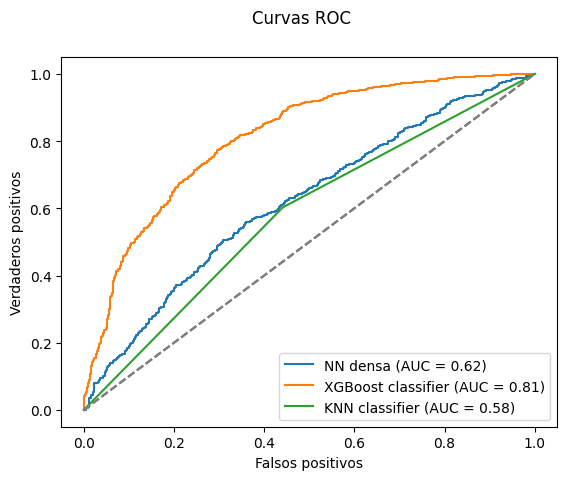

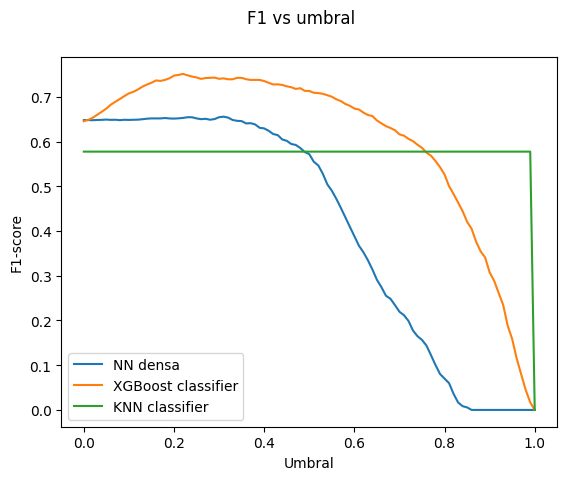

In [ ]:
plt.figure()
plt.suptitle("Curvas ROC")
for model in models:
    plt.plot(model.fpr, model.tpr, label=f'{model.name} (AUC = {model.roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.legend()
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')

plt.figure()
plt.suptitle("F1 vs umbral")
for model in models:
    plt.plot(np.linspace(0, 1, 101), model.f1, label=f'{model.name}')
    plt.legend()
    plt.xlabel('Umbral')
    plt.ylabel('F1-score')
    
plt.show()

In [55]:
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


X = pickle.load(open("evals.pkl", "rb"))
y = pickle.load(open("cheating.pkl", "rb"))
cheating_magnitude = pickle.load(open("cheating_magnitude.pkl", "rb"))

In [56]:
valid_indices = (np.abs(np.asarray(cheating_magnitude)) > 0.2) | (np.asarray(cheating_magnitude) == 0)

In [57]:
X_new = []
y_new = []
for i in np.arange(len(X))[valid_indices]:
    y_new.append(y[i])
    X_new.append(X[i])
X = X_new
y = y_new

In [58]:
from collections import Counter

counts = Counter(y)
print(f"Number of True: {counts[True]}")
print(f"Number of False: {counts[False]}")

Number of True: 5705
Number of False: 7673


In [59]:


nn_params = {'padding_length': 150, 'mask_value': 42, 'verbose': 0}
xgb_params = {'padding_length': 150, 'verbose': 0}
knn_params = {'padding_length': 150, 'verbose': 0}

models = [DenseNNClassifier(X, y, nn_params), XGBClassifier(X, y, xgb_params), KNNClassifier(X, y, knn_params)]

for model in models:
    model.build()
    
    print(f"Entrenando {model.name}...")
    model.train()
    print(f"Evaluando {model.name}...")
    model.evaluate()
    

Datos preparados para NN densa:
  - Train: (9364, 150), Val: (2676, 150), Test: (1338, 150)
Datos preparados para XGBoost classifier:
  - Train: (9364, 150), Val: (2676, 150), Test: (1338, 150)
Datos preparados para KNN classifier:
  - Train: (9364, 150, 1), Val: (2676, 150, 1), Test: (1338, 150, 1)
Modelo NN densa inicializado.
Entrenando NN densa...
Entrenamiento de NN densa completado.
Evaluando NN densa...
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━

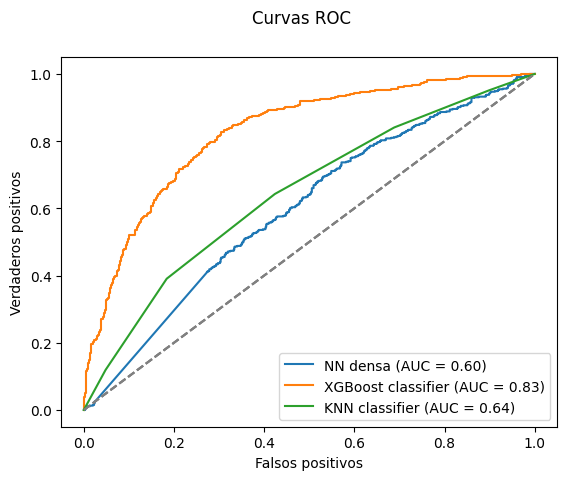

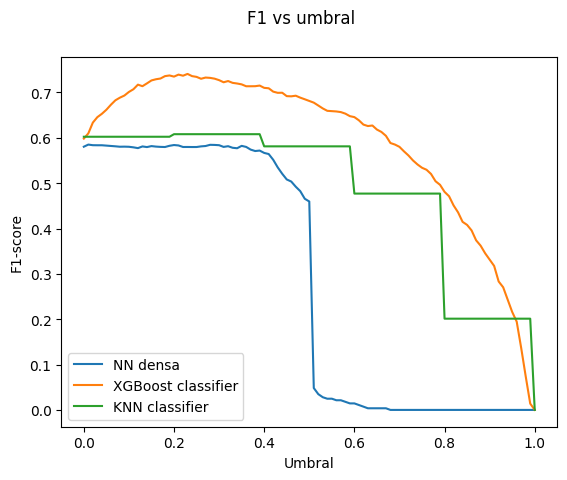

In [60]:
plt.figure()
plt.suptitle("Curvas ROC")
for model in models:
    plt.plot(model.fpr, model.tpr, label=f'{model.name} (AUC = {model.roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.legend()
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')

plt.figure()
plt.suptitle("F1 vs umbral")
for model in models:
    plt.plot(np.linspace(0, 1, 101), model.f1, label=f'{model.name}')
    plt.legend()
    plt.xlabel('Umbral')
    plt.ylabel('F1-score')
    
plt.show()

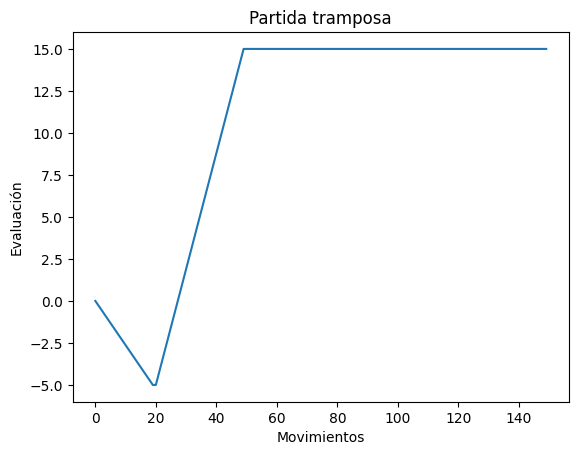

In [63]:
# Vamos a diseñar una partida "claramente" tramposa
first_20 = np.linspace(0, -5, 20)
next_30 = np.linspace(-5, 15, 30)
last_100 = np.linspace(15, 15, 100)
evals = np.concatenate([first_20, next_30, last_100])
plt.plot(evals)
plt.title("Partida tramposa")
plt.xlabel("Movimientos")
plt.ylabel("Evaluación")
plt.show()

In [71]:
# ideamos una partida imaginaria con cheating

for model in models:
    try:
        prob = model.model.predict_proba(evals[:, np.newaxis].T)
    except:
        prob = model.model.predict(evals[:, np.newaxis].T)
    try:
        print(f"El modelo {model.name} predice la probabilidad de trampas: {prob[:, 1]}")
    except:
        print(f"El modelo {model.name} predice la probabilidad de trampas: {prob[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
El modelo NN densa predice la probabilidad de trampas: [0.50920534]
El modelo XGBoost classifier predice la probabilidad de trampas: [0.7678063]


ValueError: Invalid dimensions in operator between FDataGrid (data_matrix.shape=(9364, 150, 1)) and Numpy array (shape=(9364, 150))

In [ ]:
X_func

In [82]:
from skfda.preprocessing.dim_reduction import FPCA


nn_params = {'verbose': 0}
xgb_params = {'verbose': 0}
knn_params = {'verbose': 0}

X = pickle.load(open("evals.pkl", "rb"))
y = pickle.load(open("cheating.pkl", "rb"))

X = pad_sequences(X, 150)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2 + 0.1, stratify=y, random_state=42
)
# División temp en val / test
rel_val = 0.1 / (0.2 + 0.1)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=42
)


X_func_train = FDataGrid(X_train, grid_points=np.linspace(0,1,150))
X_func = FDataGrid(X, grid_points=np.linspace(0,1,150))
pca = FPCA(n_components=20)
pca = pca.fit(X_func_train)
X = pca.transform(X_func)



models = [DenseNNClassifier(X, y, nn_params), XGBClassifier(X, y, xgb_params), KNNClassifier(X, y, knn_params)]

for model in models:
    model.build()
    
    print(f"Entrenando {model.name}...")
    model.train()
    print(f"Evaluando {model.name}...")
    model.evaluate()

Datos preparados para NN densa:
  - Train: (10271, 20), Val: (2934, 20), Test: (1468, 20)
Datos preparados para XGBoost classifier:
  - Train: (10271, 20), Val: (2934, 20), Test: (1468, 20)
Datos preparados para KNN classifier:
  - Train: (10271, 20, 1), Val: (2934, 20, 1), Test: (1468, 20, 1)
Modelo NN densa inicializado.
Entrenando NN densa...
Entrenamiento de NN densa completado.
Evaluando NN densa...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
46/46 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

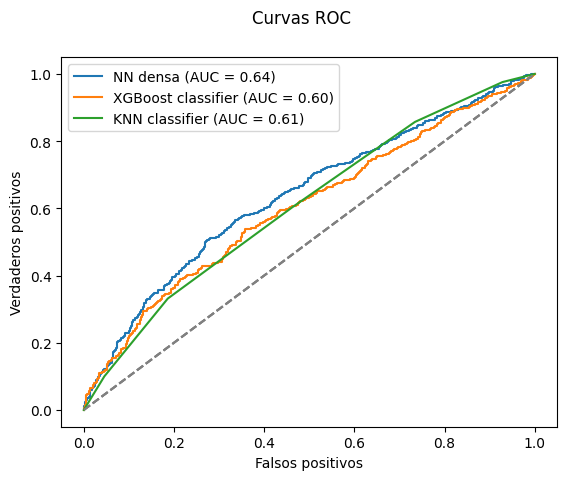

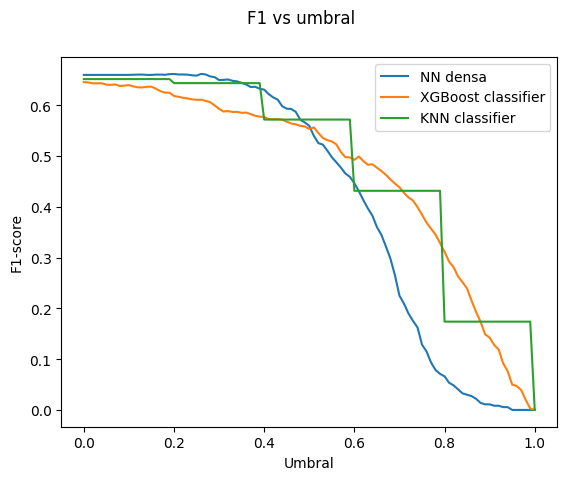

In [77]:
plt.figure()
plt.suptitle("Curvas ROC")
for model in models:
    plt.plot(model.fpr, model.tpr, label=f'{model.name} (AUC = {model.roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.legend()
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')

plt.figure()
plt.suptitle("F1 vs umbral")
for model in models:
    plt.plot(np.linspace(0, 1, 101), model.f1, label=f'{model.name}')
    plt.legend()
    plt.xlabel('Umbral')
    plt.ylabel('F1-score')
    
plt.show()

In [85]:
from skfda.preprocessing.dim_reduction import FPLS


nn_params = {'verbose': 0}
xgb_params = {'verbose': 0}
knn_params = {'verbose': 0}

X = pickle.load(open("evals.pkl", "rb"))
y = pickle.load(open("cheating.pkl", "rb"))

X = pad_sequences(X, 150)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2 + 0.1, stratify=y, random_state=42
)
# División temp en val / test
rel_val = 0.1 / (0.2 + 0.1)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=42
)


X_func_train = FDataGrid(X_train, grid_points=np.linspace(0,1,150))
X_func = FDataGrid(X, grid_points=np.linspace(0,1,150))
fpls = FPLS()
fpls = fpls.fit(X_func_train, np.asarray(y_train))
X = fpls.transform(X_func)



models = [DenseNNClassifier(X, y, nn_params), XGBClassifier(X, y, xgb_params), KNNClassifier(X, y, knn_params)]

for model in models:
    model.build()
    
    print(f"Entrenando {model.name}...")
    model.train()
    print(f"Evaluando {model.name}...")
    model.evaluate()

Datos preparados para NN densa:
  - Train: (10271, 1), Val: (2934, 1), Test: (1468, 1)
Datos preparados para XGBoost classifier:
  - Train: (10271, 1), Val: (2934, 1), Test: (1468, 1)
Datos preparados para KNN classifier:
  - Train: (10271, 1, 1), Val: (2934, 1, 1), Test: (1468, 1, 1)
Modelo NN densa inicializado.
Entrenando NN densa...
Entrenamiento de NN densa completado.
Evaluando NN densa...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 933

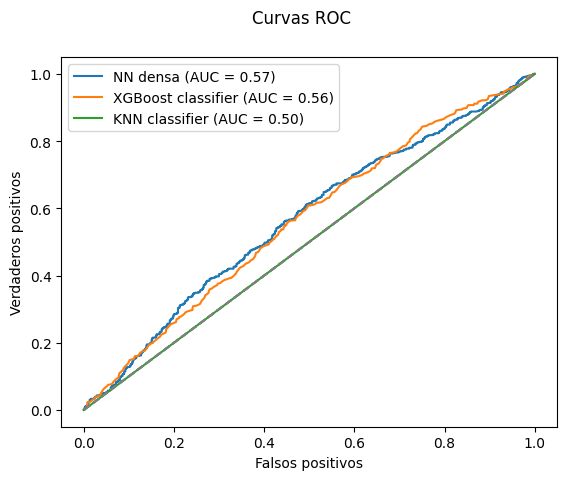

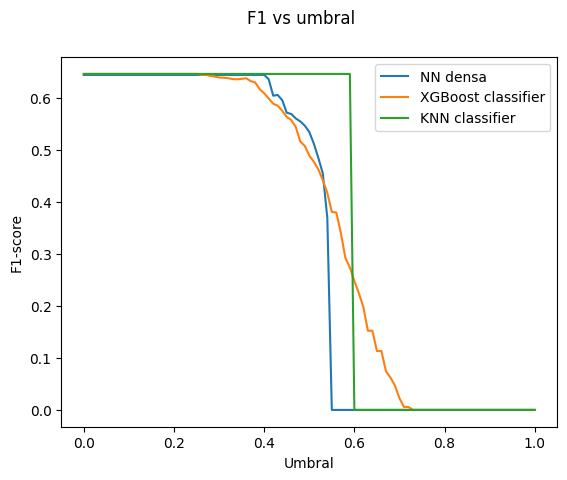

In [ ]:
plt.figure()
plt.suptitle("Curvas ROC")
for model in models:
    plt.plot(model.fpr, model.tpr, label=f'{model.name} (AUC = {model.roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.legend()
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')

plt.figure()
plt.suptitle("F1 vs umbral")
for model in models:
    plt.plot(np.linspace(0, 1, 101), model.f1, label=f'{model.name}')
    plt.legend()
    plt.xlabel('Umbral')
    plt.ylabel('F1-score')
    
plt.show()

In [ ]:
from skfda.preprocessing.dim_reduction.variable_selection import RecursiveMaximaHunting


nn_params = {'verbose': 0}
xgb_params = {'verbose': 0}
knn_params = {'verbose': 0}

X = pickle.load(open("evals.pkl", "rb"))
y = pickle.load(open("cheating.pkl", "rb"))

X = pad_sequences(X, 150)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2 + 0.1, stratify=y, random_state=42
)
# División temp en val / test
rel_val = 0.1 / (0.2 + 0.1)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=42
)


X_func_train = FDataGrid(X_train, grid_points=np.linspace(0,1,150))
X_func = FDataGrid(X, grid_points=np.linspace(0,1,150))

print("Entrenando recursive maxima hunting...")
rmh = RecursiveMaximaHunting(max_features=50)
rmh = rmh.fit(X_func_train, np.asarray(y_train))
X = rmh.transform(X_func)



models = [DenseNNClassifier(X, y, nn_params), XGBClassifier(X, y, xgb_params), KNNClassifier(X, y, knn_params)]

for model in models:
    model.build()
    
    print(f"Entrenando {model.name}...")
    model.train()
    print(f"Evaluando {model.name}...")
    model.evaluate()

In [ ]:
plt.figure()
plt.suptitle("Curvas ROC")
for model in models:
    plt.plot(model.fpr, model.tpr, label=f'{model.name} (AUC = {model.roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.legend()
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')

plt.figure()
plt.suptitle("F1 vs umbral")
for model in models:
    plt.plot(np.linspace(0, 1, 101), model.f1, label=f'{model.name}')
    plt.legend()
    plt.xlabel('Umbral')
    plt.ylabel('F1-score')
    
plt.show()